In [32]:
import pandas as pd
import numpy as np
from random import sample
from random import choices
from math import exp, sqrt
import csv
import json

In [33]:
filepath = "./datasets/Emails.csv"
headers = ["ID of from node","ID of to node", "weight", "timestamp"]

Graph = pd.read_csv(filepath, names=headers, sep=' ').drop_duplicates()
V=np.unique((Graph['ID of from node']._append(Graph['ID of to node'])).values).astype(int)
V_num = V.size

In [ ]:
# generate adjacency list for new dataset - old method
# def getValues(i):
#     return [ x[0] for x in Graph.loc[(Graph['ID of from node']==i), ['ID of to node']].drop_duplicates().values] + [ x[0] for x in Graph.loc[(Graph['ID of to node']==i), ['ID of from node']].drop_duplicates().values]

# matrix = {i: set(getValues(i)) for i in V}

In [ ]:
# generate adjacency list for new dataset - new method
matrix = {}

def add_adjacent(node, adj):
    if node not in matrix:
        adjacent = set()
        adjacent.add(adj)
        matrix[node] = adjacent
    else:
        matrix[node].add(adj)

for index, row in Graph.iterrows():
    u = int(row['ID of from node'])
    v = int(row['ID of to node'])

    if u == v: # to skip loops (in case they're present in dataset), because dissartotivity degree formula is 2m/n(n-1) (according to paper)
        continue
    
    add_adjacent(u, v)
    add_adjacent(v, u)

In [ ]:
# print adjacency list (testing purposes)
for i in V:
    print(matrix[i])

In [ ]:
# export/import generated adjacency list with whitespaces separators
def export_adj():
    filepath = "./adj-lists/adjacency-list-emails.csv"

    with open(filepath, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ')

        for node in V:
            writer.writerow([node] + list(matrix[node]))

def import_adj():
    matrix = {}
    filepath = "./adj-lists/adjacency-list-emails.csv"

    with open(filepath, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=' ')
        
        for row in reader:
            node = int(row[0])
            adjacent = set(int(row[i]) for i in range(1, len(row)))
            matrix[node] = adjacent

    return matrix

In [ ]:
# call export/import functions
# export_adj()
matrix = import_adj()

# Part 1

In [ ]:
# Часть 1. 
#Задание 1
E_num = 0
for i in V:
    for s in matrix[i]:
        if s>i:
            E_num+=1
print(f'количество вершин: {V_num};\nколичество ребер: {E_num};\nплотность: {2*E_num/(V_num*(V_num-1))}')

In [ ]:
visited = set(V)
Component = set()
answer = 0

while len(visited):
    answer += 1
    v = visited.pop()
    comp = set([v])
    candidates = matrix[v].copy()
    while len(candidates):
        newCan = set()
        for i in candidates:
            newCan.update(matrix[i])
        comp.update(candidates)
        candidates = newCan.difference(comp)
    visited -= comp
    if len(comp) > len(Component):
        Component = comp.copy()



print(f'Количество компонент слабой связности: {answer};\nРазмер максимальной компоненты: {len(Component)};\nДоля вершин в максимальной компоненте: {len(Component)/V_num}' )

In [ ]:
#задание 2
def Path_matrix_calc(subGraph : set):
    Path_matrix = {
        _from: {
             _to: V_num+1 if _from !=_to else 0
            for _to in subGraph
        }
    for _from in subGraph
    }

    V_calculated = set()
    for a in subGraph:
        V_calculated.add(a)
        V_to_calculate = (subGraph.copy()).difference(V_calculated)
        Visited = set()
        queue = [a]
        dists_queue = {a:0}
        while queue and V_to_calculate:
            u = queue.pop(0)
            dist = dists_queue.pop(u)
            Visited.add(u)
            u_visit = matrix[u].difference(Visited)
            for v in u_visit:
                if v in V_to_calculate:
                    if dist + 1 < Path_matrix[a][v]:
                        Path_matrix[a][v] = dist + 1
                        Path_matrix[v][a] = dist + 1
                        V_to_calculate.discard(v)
                if v not in dists_queue:
                    queue.append(v)
                    dists_queue[v]=dist+1
    return(Path_matrix)

In [ ]:
def Radius_Diametr_Proc(Path_matrix, subGraph: set):
    Exentr = [max(Path_matrix[node].values()) for node in subGraph]
    Radius = min(Exentr)
    Diametr = max(Exentr)
    Distances=[]
    visited = set()
    for i in subGraph:
        visited.add(i)
        for j in subGraph:
            if j not in visited:
                Distances.append(Path_matrix[i][j])
    Distances.sort()
    # Proc_90 = Distances[int(0.9*len(Distances))]
    Proc_90 = np.percentile(Distances, 90)
    return(Radius, Diametr, Proc_90)

In [ ]:
def txt_write(name, matrix, subGraph):
    with open(f'distance-lists\{name}', 'w') as f:
        f.write(str(subGraph))
        f.write('\n')
        f.write(json.dumps(matrix))

In [ ]:
#2а.
subGraph_a = set(sample(list(Component), k=500))
Path_matrix_a = Path_matrix_calc(subGraph_a)
txt_write('Path_matrix_a_prosper_loans.txt', Path_matrix_a, subGraph_a)
Radius_a, Diametr_a, Proc_90_a = Radius_Diametr_Proc(Path_matrix_a, subGraph_a)
print(f'Радиус: {Radius_a};\nДиаметр: {Diametr_a};\n90 процентиль расстояния: {Proc_90_a};')

In [ ]:
#2б.
subGraph_b = set(sample(list(Component), k=2))
nodes = subGraph_b.copy()
while len(subGraph_b)<500 and len(nodes)>0:
    u = nodes.pop()
    for i in matrix[u]:
        if len(subGraph_b) == 500:
            break
        nodes.add(i)
        subGraph_b.add(i)
Path_matrix_b = Path_matrix_calc(subGraph_b)
txt_write('Path_matrix_b_prosper_loans.txt', Path_matrix_b, subGraph_b)
Radius_b, Diametr_b, Proc_90_b = Radius_Diametr_Proc(Path_matrix_b, subGraph_b)
print(f'Радиус: {Radius_b};\nДиаметр: {Diametr_b};\n90 процентиль расстояния: {Proc_90_b};')

In [ ]:
# Задание 3
def Cl(u):
    if len(matrix[u])<2:
        return 0
    neib = matrix[u]
    G = len(neib)
    _2L=0
    for our in neib:
        _2L+=len(matrix[our].intersection(neib))
    return _2L/(G*(G-1))

CL = 0
for node in Component:
    CL+=Cl(node)
print(f'средний кластерный коэффициент сети: {CL/V_num}')

In [ ]:
# Задание 4
def R():
    r1, r2, r3, re = 0, 0, 0, 0
    for node in V:
        u = len(matrix[node])
        r1+=u
        r2+=u*u
        r3+=u*u*u
        for to in matrix[node]:
            re+=u*len(matrix[to])
    return (re*r1-r2*r2)/(r3*r1-r2*r2)

r = R()
print(f'Коэффициент ассортативности: {r}')

In [ ]:
#Часть 2.
#статические характеристики
CN_static={}
AA_static={}
JC_static={}
PA_static={}
visited=set()
for adj in V:
    visited.add(adj)
    for node in matrix[adj]:
        if node not in visited:
            inter_adj_node = matrix[adj] & matrix[node]
            CN_static[(adj, node)] = len(inter_adj_node)
            AA_=0
            for i in inter_adj_node:
                AA_+=(1/np.log10(len(matrix[i])))
            AA_static[(adj, node)] = AA_
            JC_static[(adj, node)] = len(inter_adj_node)/len(matrix[adj].union(matrix[node]))
            PA_static[(adj, node)] = len(matrix[adj])*len(matrix[node])


# Part 2

In [34]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
from scipy import integrate

In [48]:
# for weighting step
t_min = Graph['timestamp'].min()
t_max = Graph['timestamp'].max()
s = (t_max-t_min) * 0.66 + t_min

In [ ]:
# print(f'Timestamp_min: {t_min}')
# print(f'Timestamp_max: {t_max}')
# print(f'Separator: {s}')

In [50]:
# Часть 2.
# Построение векторов признаков для предсказания появления ребер в графе
# create adjacency list with timestamps:
matrix_t = dict()

for u in V:
    matrix_t[u] = dict()

def add_time (parent, child, timestamp):
    if child in matrix_t[parent]:
        matrix_t[parent][child].add(timestamp)
    else:
        timeset = set()
        timeset.add(timestamp)
        matrix_t[parent][child] = timeset

for index, _1, _2, weight, timestamp in Graph.itertuples():
    u = _1 # int(row['ID of from node'])
    v = _2 # int(row['ID of to node'])
    #timestamp = timestamp#int(row['timestamp'])

    if u == v: # skip loops
        continue

    if timestamp <= s: # work only with data from (t0, s)
        add_time(u, v, timestamp)
        add_time(v, u, timestamp)

In [37]:
# test purposes
# print(len(matrix_t))

167


In [ ]:
# test output for temporal adjacency matrix
# cnt = 0
# for i in matrix_t:
#     cnt += len(matrix_t[i].keys())

In [51]:
# Temporal features with past event aggreagtion (II-A)
# Step A: temporal weighting
l = 0.2 # same value as in paper

def weight_linear(times):
    weights = set()
    for t in times:
        T = (t - t_min) / (s - t_min)
        weights.add(l + (1 - l) * T)
    
    return weights

def weight_exp(times):
    weights = set()
    for t in times:
        T = (t - t_min) / (s - t_min)
        weights.add(l + (1 - l) * ((exp(3 * T) - 1) / (exp(3) - 1)))

    return weights

def weight_square(times):
    weights = set()
    for t in times:
        T = (t - t_min) / (s - t_min)
        weights.add(l + (1 - l) * sqrt(T))
    
    return weights

In [52]:
# Temporal features with past event aggreagtion (II-A)
# Step B: past event aggregation
def aggregate(weights):
    # q-quantiles are values that partition a finite set of values into q subsets of (nearly) equal sizes
    warr = np.array(list(weights))

    zeroth = warr.min() # 0th quantile = minimum
    first = warr.max() # 1st quantile = maximum
    second = np.median(warr) # 2nd quantile = median
    third = np.quantile(warr, 0.3) # 3rd quantile = tertile
    fourth = np.quantile(warr, 0.25) # 4th quantile = quartile

    sum = np.sum(warr)
    mean = np.mean(warr)
    variance = np.var(warr)

    return [zeroth, first, second, third, fourth, sum, mean, variance]

In [53]:
# Temporal features with past event aggreagtion (II-A)
# dict-like structure initialization (aggregated): (node1, node2): [zeroth_linear, ..., variance_linear, zeroth_exp, ..., variance_exp, zeroth_sqrt, ..., variance_sqrt]
aggregated = dict()

for node in sorted(V):
    for adj in matrix_t[node]:
        if adj > node:
            # convert set of timestamps into set of weights according to formulas
            linear = weight_linear(matrix_t[node][adj])
            exponent = weight_exp(matrix_t[node][adj])
            square = weight_square(matrix_t[node][adj])

            res = aggregate(linear)
            res += aggregate(exponent)
            res += aggregate(square)

            aggregated[(node, adj)] = res

In [41]:
# analysis
sum = 0
min = 168
max = 0
neighbors = []

for node in matrix_t:
    length = len(matrix_t[node].keys())
    neighbors.append(length)
    sum += length
    min = length if length < min else min
    max = length if length > max else max

# neighbors = np.array(neighbors)
# for i in range(len(matrix_t)):
#     print(neighbors[i])
# print(sum / V_num)
# print(min)
# print(max)
# print(st.mode(neighbors))

In [ ]:
# test aggregated
# print(len(aggregated[(1, 2)]))

In [54]:
def get_aggregated(node, z, cat):
    return aggregated[(node, z)][cat] if node < z else aggregated[(z, node)][cat]

def calculate_vector(pair):
    parent, child = pair

    parent_adj = set(matrix_t[parent].keys())
    child_adj = set(matrix_t[child].keys())
    commons = parent_adj.intersection(child_adj)

    res = []

    for category in range(24):
        AA_tmp, CN_tmp, JC_tmp = 0, 0, 0
        AA_check, JC_check = False, False

        for z in commons:
            # common part for AA, CN, JC
            num = get_aggregated(parent, z, category)
            num += get_aggregated(child, z, category)

            # Find AA_tmp
            if AA_check == False:
                AA_denum = 1

                for x in matrix_t[z].keys():
                    AA_denum += get_aggregated(z, x, category)

                if AA_denum == 1:
                    AA_check = True
                else:
                    AA_tmp += num / np.log10(AA_denum)

            # Find CN_tmp
            CN_tmp += num

            # Find JC_tmp
            if JC_check == False:
                JC_denum = 0

                for x in matrix_t[parent].keys():
                    JC_denum += get_aggregated(parent, x, category)
                for x in matrix_t[child].keys():
                    JC_denum += get_aggregated(child, x, category)
                
                if JC_denum == 0:
                    JC_check = True
                else:
                    JC_tmp += num / JC_denum

        # Find PA_tmp
        ares, bres = 0, 0

        for a in matrix_t[parent].keys():
            ares += get_aggregated(parent, a, category)
        for b in matrix_t[child].keys():
            bres += get_aggregated(child, b, category)
    
        PA_tmp = ares * bres

        # Results for current category:
        res.append(AA_tmp if AA_check == False else 0)
        res.append(CN_tmp)
        res.append(JC_tmp if JC_check == False else 0)
        res.append(PA_tmp)
    
    # print(len(res))
    return res

    

In [ ]:
# Temporal features with past event aggreagtion (II-A) - old method
# Step C: weighted topological features

# def get_aggregated(node, z, cat):
#     return aggregated[(node, z)][cat] if node < z else aggregated[(z, node)][cat]

# def AA_tmp(parent, child, commons, category):
#     # parent is always smaller than its child, but z - ?
#     res = 0

#     for z in commons:
#         num = get_aggregated(parent, z, category)
#         num += get_aggregated(child, z, category)

#         denum = 1
#         for x in matrix[z]:
#             denum += get_aggregated(z, x, category)

#         if denum == 1:
#             return 0

#         res += num / np.log10(denum)

#     return res

# def CN_tmp(parent, child, commons, category):
#     res = 0

#     for z in commons:
#         res += get_aggregated(parent, z, category)
#         res += get_aggregated(child, z, category)

#     return res

# def JC_tmp(parent, child, commons, category):
#     res = 0

#     for z in commons:
#         num = get_aggregated(parent, z, category)
#         num += get_aggregated(child, z, category)

#         denum = 0
#         for x in matrix[parent]:
#             denum += get_aggregated(parent, x, category)
#         for x in matrix[child]:
#             denum += get_aggregated(child, x, category)
        
#         if denum == 0:
#             return 0
        
#         res += num / denum
    
#     return res

# def PA_tmp(parent, child, commons, category):
#     ares = 0
#     bres = 0

#     for a in matrix[parent]:
#         ares += get_aggregated(parent, a, category)
#     for b in matrix[child]:
#         bres += get_aggregated(child, b, category)
    
#     return ares * bres

In [57]:
# choose potential pairs
# (u, v) with distance 2 (so they're not connected in [t0, s])
potential_pairs = set()

for u in V:
    u_adj = set(matrix_t[u].keys())
    for v in V:
        v_adj = set(matrix_t[v].keys())
        if u not in matrix_t[v].keys() and u_adj.intersection(v_adj):
            if u < v:
                potential_pairs.add((u, v))


In [58]:
# take all yes/no pairs from potential pairs
# y_sample: will connect in (s, t1]
# n_sample: won't connect in (s, t1]
positive_pairs = set() # all node pairs that will connect
negative_pairs = set() # all node pairs that will not connect

for u, v in potential_pairs:
    if v in matrix[u]:
        positive_pairs.add((u, v))

# n_pairs = [(pair, 0) for pair in set(potential_pairs).difference(set(y_pairs))]
negative_pairs = potential_pairs.difference(positive_pairs)

In [ ]:
# for u, v in y_pairs:
#     print("Will connect:", u, v)
#     print(len(y_pairs))
#     break

# for u, v in n_pairs:
#     print("Will not connect:", u, v)
#     print(len(n_pairs))
#     break

In [46]:
# bad way of initializing sampling of yes\no
stop = 500
y_sample = dict()
n_sample = dict()

for index, _1, _2, weight, timestamp in Graph.itertuples():
    u = _1#int(row['ID of from node'])
    v = _2#int(row['ID of to node'])
    #timestamp = timestamp#int(row['timestamp'])

    if u == v: # skip loops
        continue

    if (u, v) in potential_pairs and timestamp > s:
        if len(y_sample) >= stop:
            break

        y_sample[(u, v)] = []

    if (v, u) in potential_pairs:
        if len(y_sample) >= stop:
            break

        y_sample[(v, u)] = []

leftovers = potential_pairs.difference(set(y_sample.keys()))

for u, v in leftovers:
    if len(n_sample) >= stop:
        break

    n_sample[(u, v)] = []


In [59]:
# choose samples with replacement
samples_num = 250

positive_samples = choices(list(positive_pairs), k=samples_num)
negative_samples = choices(list(negative_pairs), k=samples_num)

In [68]:
# Temporal features with past event aggreagtion (II-A)
# Step C: weighted topological features for chosen samples only;
X_positive = [[] for i in range(samples_num)]
# labels_positive = []
# y_positive = [1] * samples_num

X_negative = [[] for i in range(samples_num)]
# lables_negative = []
# y_negative = [0] * samples_num

for i in range(samples_num):
    X_positive[i] = calculate_vector(positive_samples[i])
    X_negative[i] = calculate_vector(negative_samples[i])

In [69]:
# separate calculated feature vectors into 2 groups: train (for learning) and test (for prediction)
border = round(samples_num * 0.75)

X_train = X_positive[:border] + X_negative[:border]
y_train = np.array([1]* border + [0]* border)

X_test = X_positive[border:] + X_negative[border:]
y_test = np.array([1]*(samples_num-border) + [0]*(samples_num-border))

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [ ]:
# print(border)
# print(len(X_train))
# print(len(X_test))

In [70]:
# make instance of model
logisticRegr = LogisticRegression(max_iter=1000)

# train model: learning the relationship between feature vectors (X_train) and labels (y_train)
logisticRegr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [77]:
# predict
# Predict for One Observation (image)
answer = logisticRegr.predict_proba(X_test)[:, 1]

[[0.45429814 0.54570186]
 [0.47948724 0.52051276]
 [0.43481295 0.56518705]
 [0.47794166 0.52205834]
 [0.77827638 0.22172362]]


In [89]:
def FRP_TPR(limit, answer_, Ytest):
    FP, TN, TP, FN = 0, 0, 0, 0
    for i in range(len(answer_)):
        if answer_[i]>=limit and Ytest[i]==1:
            TP+=1
        elif answer_[i]>=limit:
            FP+=1
        elif Ytest[i]==1:
            FN+=1
        else:
            TN+=1
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    return FPR, TPR


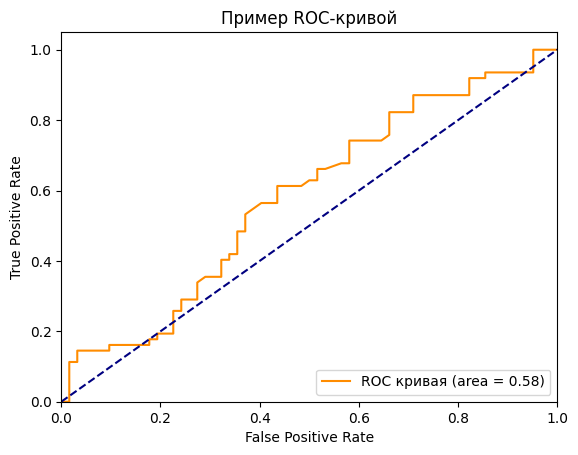

In [106]:
# строим график
limit = np.linspace(0, 1, 1000)
fpr, tpr = [], []
for l in limit: 
    res = FRP_TPR(l, answer, y_test)
    fpr.append(res[0])
    tpr.append(res[1])
roc_auc = integrate.trapz(tpr[::-1], fpr[::-1])
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Пример ROC-кривой')
plt.legend(loc="lower right")
plt.show()